In [1]:
import os
os.environ["CC"] = "gcc"
os.environ["CXX"] = "gcc"

In [2]:
import sys
sys.path.append('/usr/lib/python3/dist-packages')
print(sys.path)


['/home/beast2020/Desktop/mingchi/PixTransform-save_params', '/home/beast2020/anaconda3/lib/python38.zip', '/home/beast2020/anaconda3/lib/python3.8', '/home/beast2020/anaconda3/lib/python3.8/lib-dynload', '', '/home/beast2020/.local/lib/python3.8/site-packages', '/home/beast2020/anaconda3/lib/python3.8/site-packages', '/home/beast2020/.local/lib/python3.8/site-packages/IPython/extensions', '/home/beast2020/.ipython', '/usr/lib/python3/dist-packages']


In [3]:
import os
os.environ["OMP_PROC_BIND"] = os.environ.get("OMP_PROC_BIND", "true")

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
%matplotlib inline

from pix_transform.pix_transform import PixTransform
from baselines.baselines import bicubic
from utils.utils import downsample,align_images
from prox_tv import tvgen
from utils.plots import plot_result

## EPFL oblique

In [4]:
# %env CUDA_VISIBLE_DEVICES=1

In [5]:
import imageio
import torch

In [6]:
directory = os.path.dirname(os.getcwd())
directory

'/home/beast2020/Desktop/mingchi'

In [7]:
rgb_dir = directory+'/EPFL_10_newsample_ob/rgb/'
_files = os.listdir(rgb_dir)
_files.sort()
_rgb_files = [rgb_dir + f for f in _files]
_rgb_files.sort()
print(_rgb_files)

dist_dir = directory+'/EPFL_10_newsample_ob/dist/'
_files = os.listdir(dist_dir)
_files.sort()
_dist_files = [dist_dir + f for f in _files]
_dist_files.sort()
print(_dist_files)

['/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01120_100_0003_0332.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01121_100_0003_0333.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01122_100_0003_0334.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01154_100_0003_0366.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01155_100_0003_0367.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01156_100_0003_0368.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01164_100_0003_0376.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01165_100_0003_0377.png', '/home/beast2020/Desktop/mingchi/EPFL_10_newsample_ob/rgb/EPFL-2020-09-24-planned_01167_100_0003_0379.png', '/home/beast2020/Desktop/mi

In [8]:
guide_imgs = []
target_imgs= []

for num in range(len(_rgb_files)):
    rgb_img = imageio.imread(_rgb_files[num])
    guide_imgs.append(rgb_img)
    dist_img = torch.load(_dist_files[num])
    dist_img = dist_img.detach().cpu().numpy()
    target_imgs.append(dist_img)
        
guide_imgs = np.asarray(guide_imgs)
guide_imgs = np.einsum('ijkl->iljk', guide_imgs)        
target_imgs = np.asarray(target_imgs)

In [9]:
print(guide_imgs.shape)
print('max value in the image is: ' + str(guide_imgs.max()))
print('min value in the image is: ' + str(guide_imgs.min()))

(10, 3, 480, 720)
max value in the image is: 255
min value in the image is: 0


In [10]:
print(target_imgs.shape)
print('max value in the image is: ' + str(target_imgs.max()))
print('min value in the image is: ' + str(target_imgs.min()))

(10, 480, 720)
max value in the image is: 191.55736
min value in the image is: 70.43551


In [11]:
####  define parameters  ########################################################
params = {'img_idxs' : [], # idx images to process, if empty then all of them
            
          'scaling': 8,
          'greyscale': False, # Turn image into grey-scale
          'channels': -1,
          
          'spatial_features_input': True,
          'weights_regularizer': [0.0001, 0.001, 0.0001], # spatial color head
          'loss': 'l1',
 
          'optim': 'adam',
          'lr': 0.001,
                  
          'batch_size': 32,
          'iteration': 1024*60*90//32, # could //4 or //16 for debugging, so to save time
                  
          'logstep': 16,
          
          'final_TGV' : False, # Total Generalized Variation in post-processing
          'align': False, # Move image around for evaluation in case guide image and target image are not perfectly aligned
          'delta_PBP': 1, # Delta for percentage of bad pixels 
         }



In [12]:
directory

'/home/beast2020/Desktop/mingchi'

####### image 1/10 - image idx 0 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[22.799734   3.4213827  2.3806977  2.4060938  2.272754   2.0788407
  2.0283957  1.9924117  2.0588691  2.022155   1.8501401  1.8259346
  1.902921   1.8308836  2.0690246  1.91865    1.8160634  1.9330045
  1.8287984  1.9986517  1.8399353  1.8319135  1.7810475  1.9246558
  1.7355584  2.192622   1.7297258  1.8328267  1.7397006  1.790649
  1.7987688  1.7616547  1.8087063  1.9119285  1.7608153  1.7314768
  2.0679538  1.7052453  1.819967   1.7684917  1.7962283  1.6984794
  1.8082091  1.7960992  1.9398491  1.8403041  1.7130421  1.7906054
  1.7673364  1.7194021  1.654494   1.6591775  1.7945721  1.7764032
  1.7039477  1.8482463  1.6925517  1.8097179  1.7556219  1.7837449
  1.694037   1.698431   1.7225922  1.7944304]
----------MAE----------
(64,)
[3.0116024  1.2944616  0.8970438  0.9323034  0.83622444 0.7212247
 0.7318286  0.71548504 0.7907145  0.6960153  0.69710016 0.66393584
 0.6682741  0.69532543 0.8121054  0.7575268  0.64391947 0.70527184
 0.6281732  0.7122115  0.

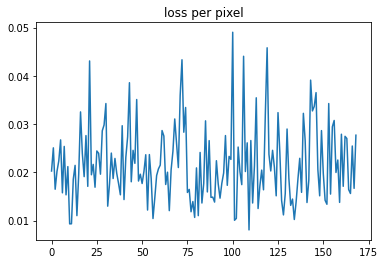

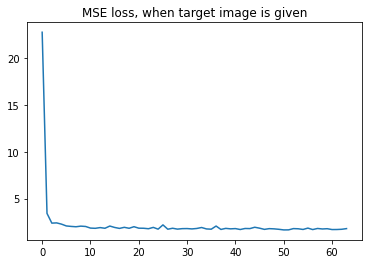

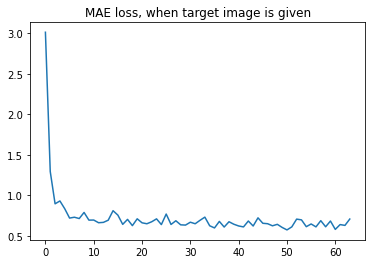

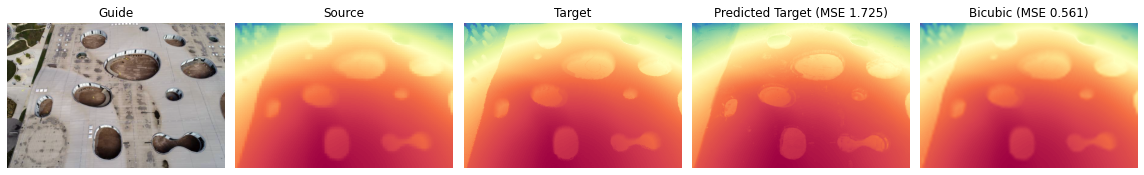

MSE: 1.725  ---  MAE: 0.638  ---  PBP: 0.136



####### image 2/10 - image idx 1 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[8.738713  4.711117  3.171465  2.5707023 2.6154785 2.242401  2.284878
 2.037418  1.9760455 2.0148256 1.945467  1.9115729 1.8833959 1.8685386
 1.89566   1.8474516 1.9010528 1.8023196 1.8077823 1.8683583 1.8305689
 1.9173983 1.7832718 1.7774647 1.9597557 1.744524  1.71625   1.7715945
 1.8070186 1.8132975 1.8897643 1.785791  1.7811733 1.7839799 1.7171532
 1.6799651 1.7358909 1.6906651 1.6692475 1.7177414 1.738878  1.7942744
 1.671663  1.7295719 1.7357408 1.7458112 1.781235  1.5915997 1.6020577
 1.6775879 1.7060263 1.6214471 1.6620545 1.6390144 1.8041091 1.6196405
 1.7026906 1.6283106 1.7749168 1.5615776 1.710315  1.5626001 1.6236683
 1.6281693]
----------MAE----------
(64,)
[2.176499   1.5025543  1.1596781  0.9546991  1.0420594  0.8524527
 0.908002   0.77378255 0.75361335 0.7857577  0.7488142  0.72998387
 0.7092964  0.6766966  0.69826543 0.7227776  0.7376064  0.6885107
 0.65275633 0.6880828  0.7025975  0.73676544 0.68019164 0.71251404
 0.7293395  0.6791956  0

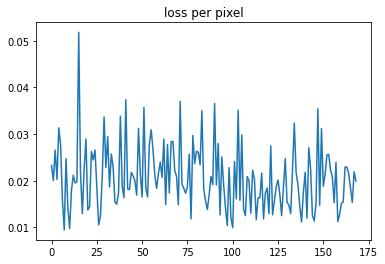

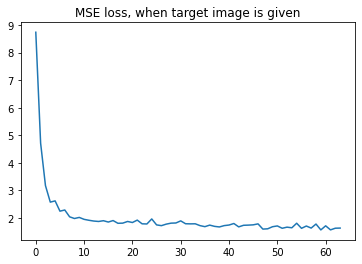

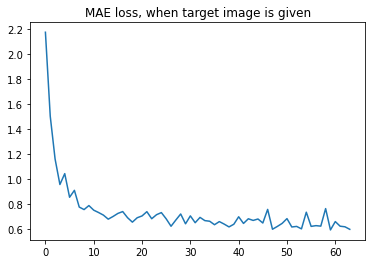

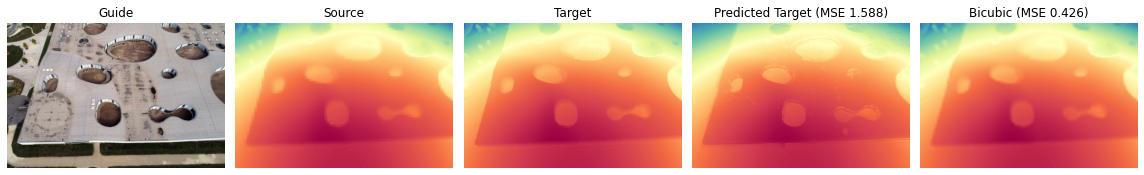

MSE: 1.588  ---  MAE: 0.603  ---  PBP: 0.143



####### image 3/10 - image idx 2 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[8.440364  3.082117  2.8203204 2.384754  2.7214935 2.093869  2.1013813
 1.8842014 1.8249574 1.8187482 1.8552957 1.8675689 1.7631071 1.6973007
 1.8044382 1.7751725 1.7452177 1.7794068 1.8254576 1.6879027 1.668528
 1.6649792 1.7268094 1.6555876 1.6153165 2.062597  1.8213968 1.7114586
 1.5703666 1.9196665 1.5150465 1.52977   1.5788645 1.6139055 1.649624
 1.5355147 1.4935685 1.4687606 1.5030942 1.5415623 1.6135876 1.5261545
 1.4899614 1.715195  1.5119506 1.5938119 1.4809874 1.4658489 1.5166987
 1.4652573 1.607836  1.4958988 1.6574682 1.4488561 1.433638  1.6148181
 1.3720697 1.4416497 1.4846107 1.4483885 1.4037484 1.3904271 1.4604019
 1.4328548]
----------MAE----------
(64,)
[1.9939772  1.08575    0.96637857 0.86399406 0.9645622  0.80238044
 0.7421949  0.7225164  0.69006056 0.696338   0.7320348  0.7022536
 0.6480025  0.628436   0.6923286  0.664854   0.6981124  0.7178214
 0.67951953 0.6622106  0.65225327 0.6522292  0.653676   0.64378244
 0.6094167  0.8729796  0.

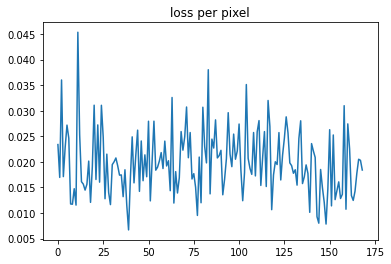

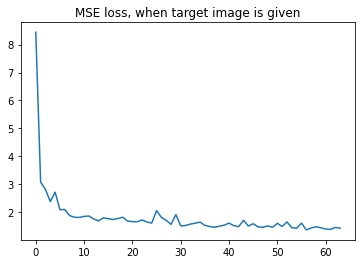

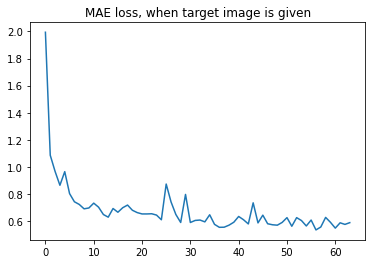

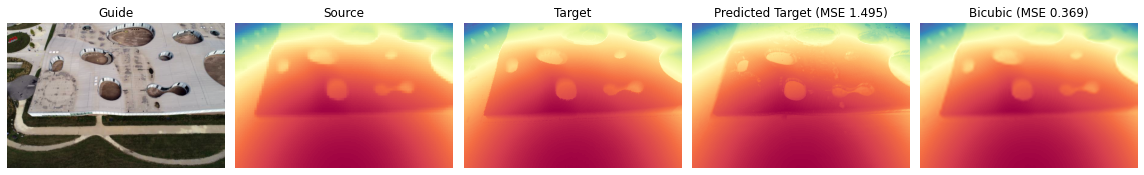

MSE: 1.495  ---  MAE: 0.592  ---  PBP: 0.134



####### image 4/10 - image idx 3 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[34.784786  15.521068  10.43276    9.677187   7.0132422  7.861856
  6.8352027  7.5203357  6.897205   6.92119    5.667017   5.9434543
  5.9428263  5.7474003  5.606393   5.7350955  5.430043   7.586419
  5.0699816  5.4945774  5.1094384  5.1965013  5.1904964  5.377041
  5.483569   5.0044856  5.1087046  4.738575   4.7110567  5.4159565
  5.254779   5.0684037  5.1215844  4.692069   4.895926   4.6093984
  5.200142   4.7969017  4.8956866  4.9470234  4.610283   4.86199
  6.013737   4.510161   4.3698273  4.6628737  5.227363   4.4268694
  4.6339035  4.6389318  4.429853   4.878626   4.483057   4.8703704
  4.3363867  4.3511596  4.367123   4.512506   5.8093777  4.3993263
  5.1334167  4.107562   4.4185567  4.541018 ]
----------MAE----------
(64,)
[3.9639533 2.5854518 2.0602949 2.102216  1.5784367 1.7044488 1.643967
 1.6132973 1.6059448 1.4904027 1.4090213 1.4017553 1.3884383 1.4202757
 1.3927215 1.368924  1.3220781 1.6706064 1.2662827 1.4023567 1.2648739
 1.275894  1.2738

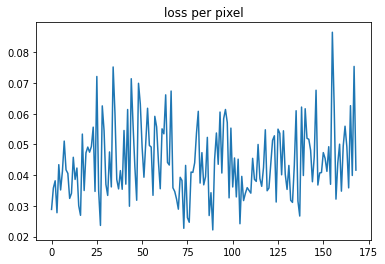

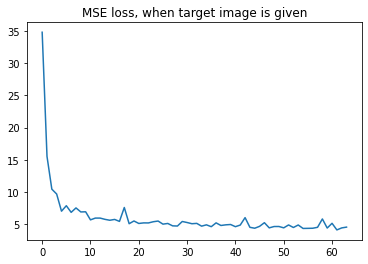

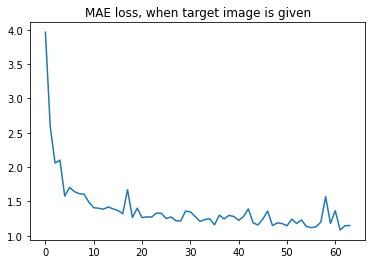

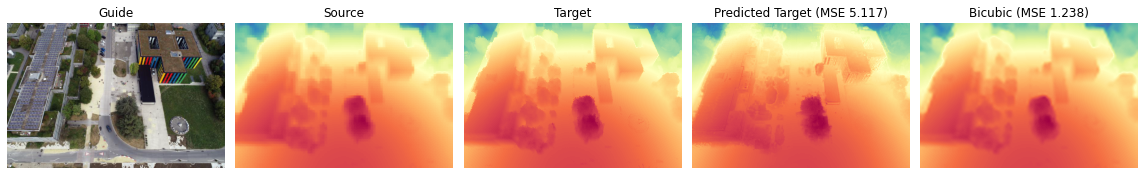

MSE: 5.117  ---  MAE: 1.340  ---  PBP: 0.375



####### image 5/10 - image idx 4 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[42.548927  14.030495  11.29865    9.349008   8.91853    8.945704
  7.582727   7.4624443  7.004153   7.1922626  6.6402416  6.826881
  7.487583   7.842811   6.7031193  6.416872   6.0635424  5.8622265
  6.096126   6.3160806  5.6666765  6.5478716  5.6504545  5.420147
  5.43282    5.3380184  5.2541075  5.99685    5.6808195  5.3198514
  5.139991   5.3923078  5.2049084  5.112927   4.9067817  4.844444
  4.918669   4.7960134  5.275883   4.6970196  5.0986633  4.85355
  4.805034   5.199219   4.804338   4.565763   4.550655   4.7270956
  4.680096   4.4280167  4.6923156  5.313128   4.910771   4.647452
  4.6784525  4.492081   4.71017    4.573417   4.170868   4.4395185
  4.4168916  4.583429   4.725761   4.916234 ]
----------MAE----------
(64,)
[4.3148413 2.5007644 2.0338943 1.9233116 1.917365  1.8612698 1.6402304
 1.619383  1.564332  1.6258181 1.5604718 1.5871137 1.697281  1.7232568
 1.5503774 1.546386  1.4606675 1.4217205 1.4846604 1.4973875 1.4398528
 1.4983058 1.41840

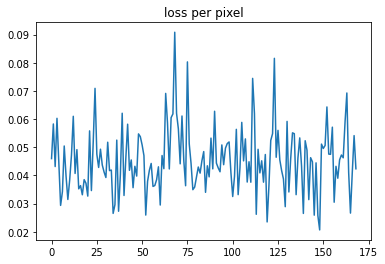

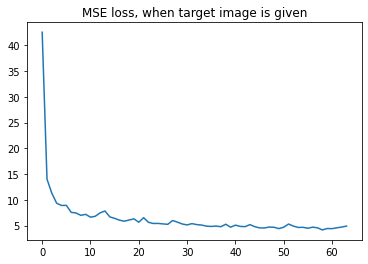

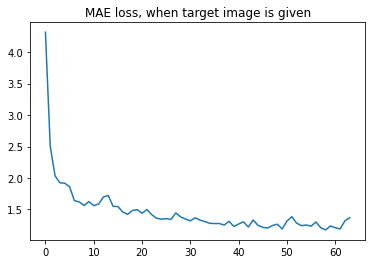

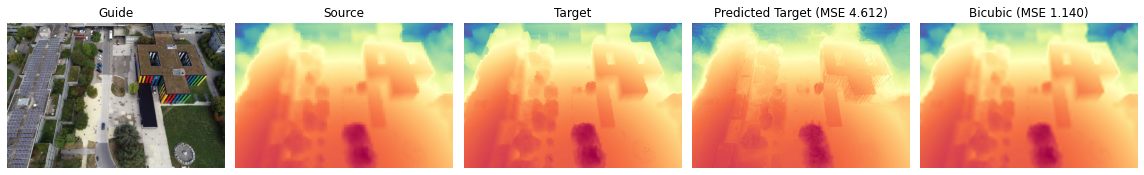

MSE: 4.612  ---  MAE: 1.281  ---  PBP: 0.395



####### image 6/10 - image idx 5 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[37.3014    10.235937   8.8907175  7.43297    7.3367906  6.6939707
  7.05511    6.5248394  6.4312296  6.204129   6.7792187  6.0756736
  5.777306   5.6329885  6.0601892  6.279868   5.3438644  5.2066474
  5.89211    5.3552337  5.2082124  5.108129   5.5753126  5.33328
  4.9953604  5.2001657  4.9101634  5.0938334  5.337785   5.3366885
  5.101534   5.3853164  5.3023944  4.814506   5.8124433  5.1147447
  4.8547416  5.1677256  5.030275   4.979428   4.7737565  4.709729
  5.1617093  5.073115   4.583195   4.7576947  4.5624557  5.285949
  4.637519   4.8581758  4.84661    4.846935   5.6044836  4.6723185
  4.7244377  4.605272   4.909541   4.709067   4.7043715  4.4960895
  5.0441885  4.381853   4.4807057  4.4317803]
----------MAE----------
(64,)
[4.599083  2.0473416 1.9831449 1.8163294 1.7304062 1.5892216 1.6622899
 1.4908696 1.5220367 1.460995  1.6277122 1.4356745 1.4681809 1.4484104
 1.5099493 1.5225128 1.4361999 1.3721389 1.4677871 1.4319636 1.3778133
 1.3210088 1.34

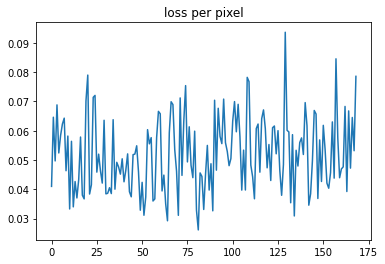

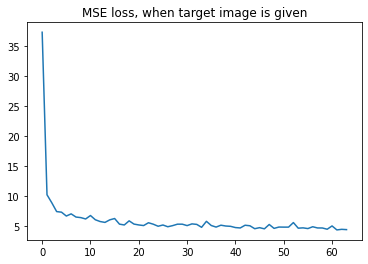

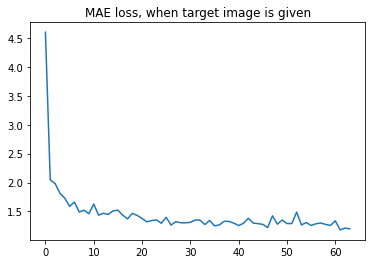

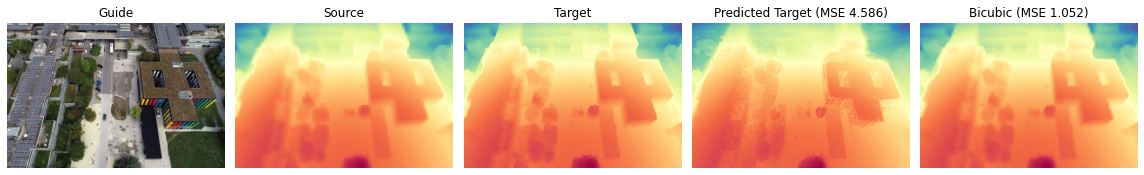

MSE: 4.586  ---  MAE: 1.194  ---  PBP: 0.343



####### image 7/10 - image idx 6 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[45.496975  15.475683  12.780156  12.495688  11.065925  10.251664
  9.975363   9.554417   9.799757   9.455349  10.36056    9.429323
  9.050399   8.487405   8.241675   8.804079  10.007546   8.176711
  9.230391   8.525214   7.988884   8.333106   7.9004507  7.513307
  7.680379   7.945156   8.309194   8.039491   7.481025   7.7938013
  7.7683716  7.7122064  7.554016   7.4098053  8.197813   7.9514093
  8.719811   7.6495123  7.4595513  7.540119   7.6386905  7.473268
  7.0393476  7.7411675  7.84864    7.393419   7.3829284  7.4283056
  7.103892   7.3874493  6.9547915  8.024622   7.3734117  7.6978574
  7.050089   7.9256096  7.494089   7.0309086  7.601862   6.819226
  7.124355   6.974116   6.9908056  7.768452 ]
----------MAE----------
(64,)
[4.9191356 2.5731351 2.3022366 2.2155597 2.1136    1.9286245 1.8573344
 1.863642  1.9320283 1.8901429 1.8504121 1.8665915 1.7520255 1.6822866
 1.6543925 1.8449035 1.9320958 1.6847305 1.8529774 1.7027962 1.6095947
 1.6730789 1.5991

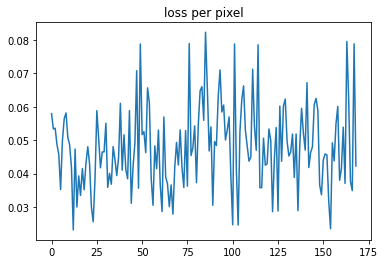

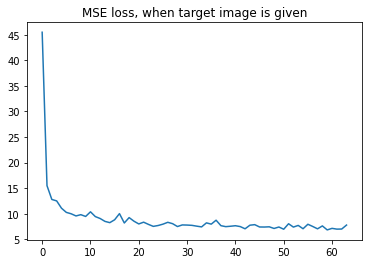

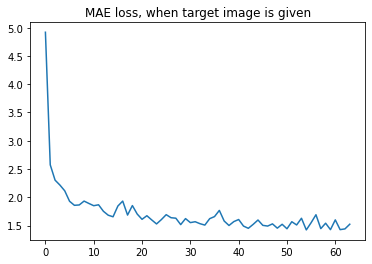

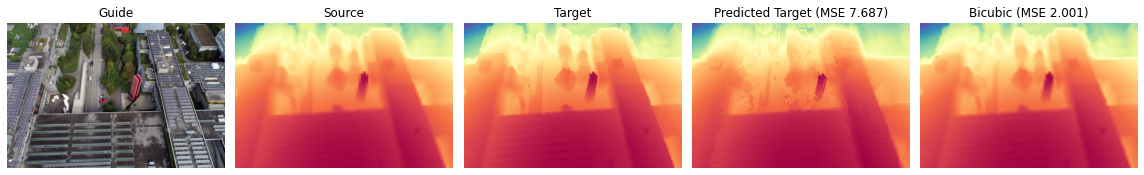

MSE: 7.687  ---  MAE: 1.599  ---  PBP: 0.446



####### image 8/10 - image idx 7 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[44.567287  16.676891  18.076199  12.2835245 10.510434  11.527808
 10.287192  11.070488   9.569664   8.947333   8.07374    8.206181
  9.000361   7.609518  10.747486   7.339193   7.6001987  7.9146686
  7.084948   7.219095   6.7484713  6.6784644  6.8255353  8.126696
  6.8354607  6.7482696  7.003606   6.9730873  7.3827257  7.1289916
  6.5987377  6.43797    7.170884   6.801004   6.5634847  6.532186
  6.2376304  6.4097195  6.4404593  6.19055    7.37282    6.719423
  6.604355   6.559233   6.468936   6.325769   6.3712196  5.959187
  6.2049427  6.28479    6.3264165  6.254939   5.9282994  5.9389715
  6.490536   6.6590886  6.0790625  5.8684745  5.9542375  5.9375935
  6.18796    5.961619   6.135031   6.737691 ]
----------MAE----------
(64,)
[4.9731607 2.7021863 2.9093103 2.1387172 1.9303219 2.0915074 1.8594922
 1.9362621 1.7913162 1.748846  1.5940452 1.6189905 1.6873745 1.5473874
 1.8128253 1.5173477 1.5909518 1.620076  1.4848567 1.4932687 1.4310298
 1.3771873 1.4200

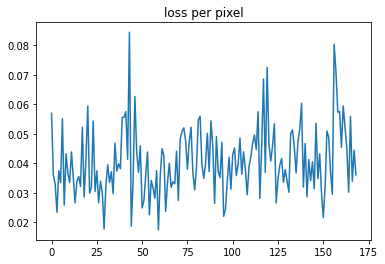

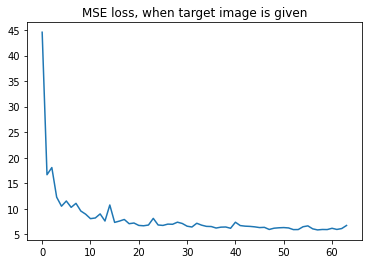

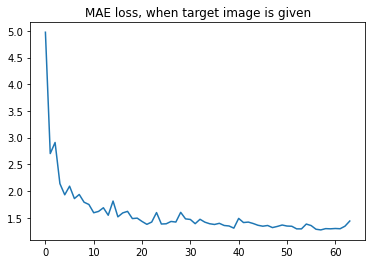

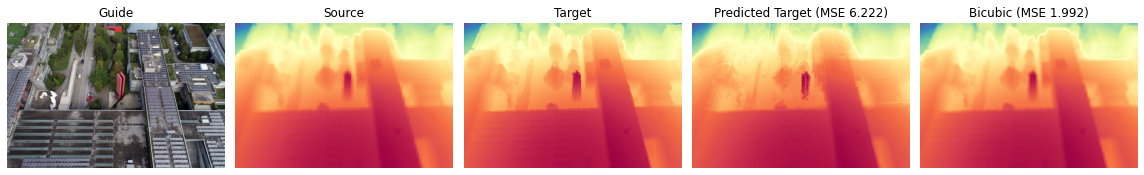

MSE: 6.222  ---  MAE: 1.313  ---  PBP: 0.339



####### image 9/10 - image idx 8 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[33.75993   19.708088  15.666897  13.8206625 12.61453   11.474555
 11.122583  10.656818  10.562993   9.882871   9.621384   9.714335
  9.360925   9.504171   9.32725    8.929305   9.146671   8.986762
  8.587173   9.542236   8.602789   8.0375     7.8706107  8.156267
  7.551997   7.4924293  7.500729   8.423003   7.6184635  7.456493
  7.039817   7.187815   6.8618836  7.640787   7.2096815  6.743845
  6.8762126  6.7014165  6.640275   7.008407   6.955591   7.455693
  6.5705066  6.37853    7.527345   6.3009157  6.24331    6.623965
  6.4220066  6.4636602  6.617819   6.414095   6.53565    6.474103
  6.923404   6.6321077  6.201874   6.098941   6.480862   6.2275724
  6.1543093  6.1399336  6.7485223  6.093992 ]
----------MAE----------
(64,)
[4.2584004 2.8202567 2.5056622 2.313794  2.2347944 2.0319405 1.9745163
 1.997262  1.8924499 1.8459725 1.7681556 1.7610202 1.7407849 1.7715697
 1.7255664 1.7107875 1.8014022 1.7078631 1.6535019 1.7382892 1.6721755
 1.6144568 1.5142292

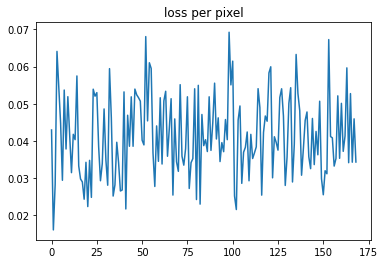

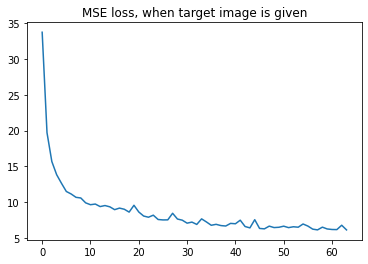

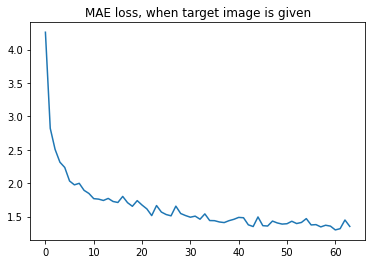

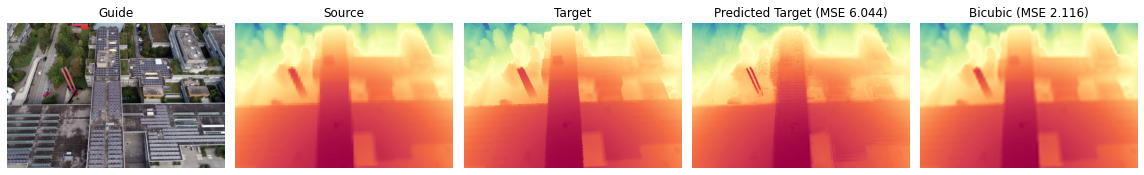

MSE: 6.044  ---  MAE: 1.333  ---  PBP: 0.360



####### image 10/10 - image idx 9 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(64,)
[33.297493  21.732868  18.859638  14.75275   14.6439495 13.720816
 11.89252   12.433166  10.822023  10.710904  10.61091   11.899485
 10.268598   9.688831   9.700077   9.346104  10.253877   8.929252
  8.750061   8.653061   9.034952   8.703266   8.856833   8.34666
  8.1556635  8.1215515  8.150341   9.256248   8.494429   8.428555
  8.237329   7.7494183  7.80559    7.878983   8.02987    8.201545
  8.226056   8.38711    8.08477    7.905217   7.7115054  7.412721
  7.6199245  7.640064   7.6113496  7.823242   8.7486315  8.189769
  7.337388   7.832349   8.380306   7.8066235  7.251854   7.365198
  7.2050548  6.9600115  7.056294   7.6102653  7.263885   7.334686
  6.9434276  7.0980144  7.1260395  7.103387 ]
----------MAE----------
(64,)
[4.0251737 3.0441952 2.823261  2.3718534 2.419866  2.251966  2.0878146
 2.3149884 1.9438581 1.941359  1.936869  2.1252892 1.9780465 1.86071
 1.8758011 1.8595117 1.9193381 1.7495826 1.745946  1.8081006 1.7765093
 1.7669423 1.7465723 1.6

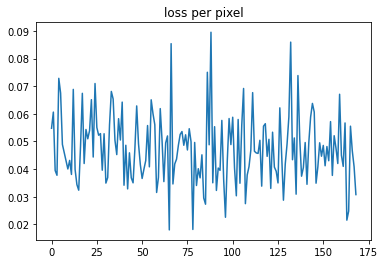

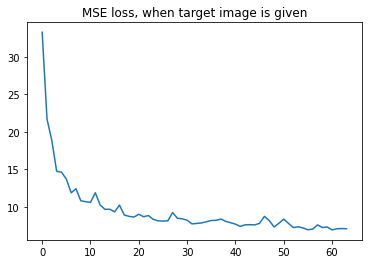

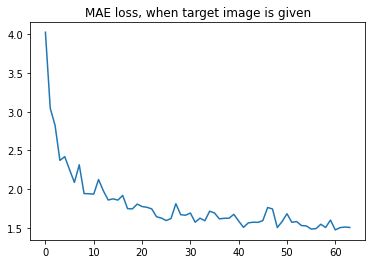

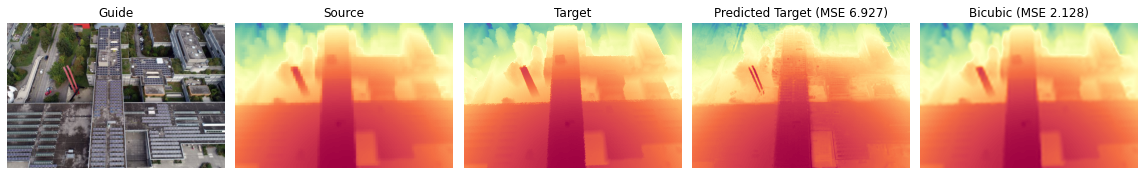

MSE: 6.927  ---  MAE: 1.489  ---  PBP: 0.400





In [13]:
if len(params['img_idxs'])==0:
    idxs = np.array(range(0,target_imgs.shape[0]))
else:
    idxs = params['img_idxs']

for n_image,idx in enumerate(idxs):
    
    print("####### image {}/{} - image idx {} ########".format(n_image+1,len(idxs),idx))
    
    guide_img = guide_imgs[idx]
    target_img = target_imgs[idx]
    source_img = downsample(target_img,params['scaling'])
    save_path = directory+'/saved_model_EPFL_oblique/model'+str(idx)+'.pt'
    # check if the directory exist
    os.makedirs(os.path.dirname(save_path),exist_ok=True)
    
    bicubic_target_img = bicubic(source_img=source_img, scaling_factor=params['scaling'])
    
    predicted_target_img = PixTransform(guide_img=guide_img,source_img=source_img,params=params,target_img=target_img, path = save_path)
    


    if params['final_TGV'] :
        print("applying TGV...")
        predicted_target_img = tvgen(predicted_target_img,[0.1, 0.1],[1, 2],[1, 1])
        
    if params['align'] :
        print("aligning...")
        target_img,predicted_target_img = align_images(target_img,predicted_target_img)

    f, ax = plot_result(guide_img,source_img,predicted_target_img,bicubic_target_img,target_img)
    plt.show()
    
    if target_img is not None:
        # compute metrics and plot results
        MSE = np.mean((predicted_target_img - target_img) ** 2)
        MAE = np.mean(np.abs(predicted_target_img - target_img))
        PBP = np.mean(np.abs(predicted_target_img - target_img) > params["delta_PBP"])

        print("MSE: {:.3f}  ---  MAE: {:.3f}  ---  PBP: {:.3f}".format(MSE,MAE,PBP))
        print("\n\n")
 



### Change upsampling to 40

In [14]:
torch.cuda.empty_cache()

####### image 1/10 - image idx 0 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[313.77603     6.423968    6.521419    7.4839597   4.1364107   4.4587955
   4.480227    4.190343    3.777113    4.0212398   3.8892086   3.9842668
   5.963408    3.8825908   4.0243864   4.311379 ]
----------MAE----------
(16,)
[12.667941   1.6233637  1.6488307  1.9984887  1.235503   1.3292935
  1.2696605  1.2614815  1.2132844  1.2470943  1.1963394  1.3052391
  1.6536093  1.1782836  1.2188828  1.2944896]


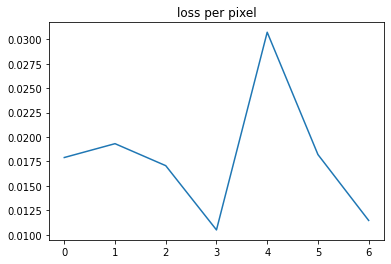

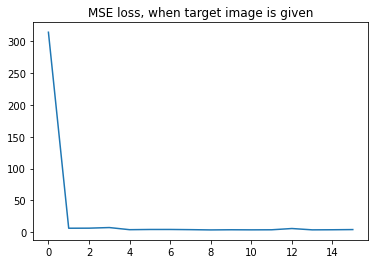

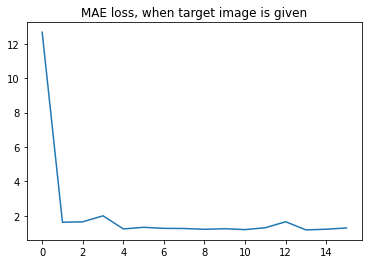

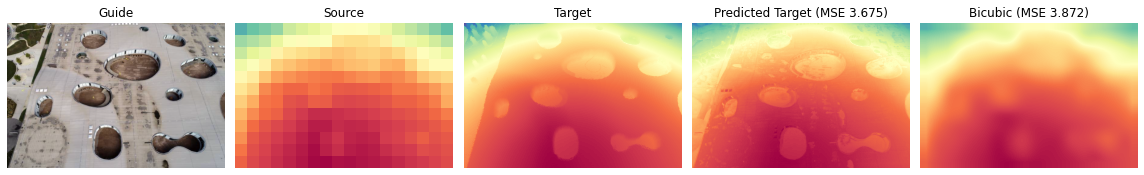

MSE: 3.675  ---  MAE: 1.240  ---  PBP: 0.379



####### image 2/10 - image idx 1 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[352.404       7.057108    5.281144    5.711227    4.4970646   4.595491
   4.254106    3.9536562   4.4043317   4.9144387   3.758724    3.87413
   4.2478833   3.599161    3.6243215   3.9421022]
----------MAE----------
(16,)
[14.98807    1.8634158  1.5628455  1.6355327  1.3471664  1.4482476
  1.334283   1.2835536  1.3868818  1.6044159  1.2051438  1.2467941
  1.3274044  1.1765522  1.1674347  1.22928  ]


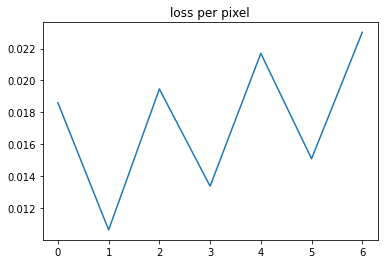

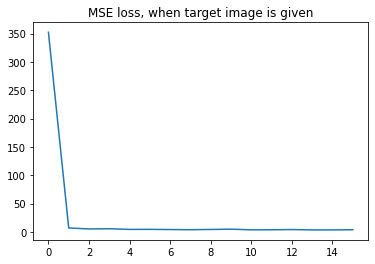

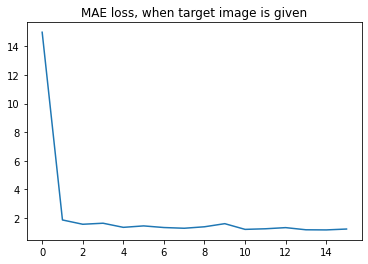

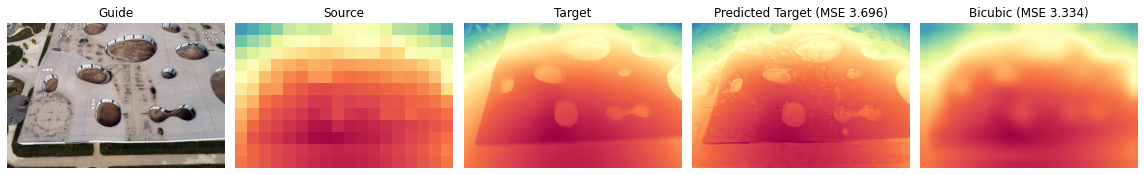

MSE: 3.696  ---  MAE: 1.214  ---  PBP: 0.371



####### image 3/10 - image idx 2 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[415.56686     5.5480466   5.3237286   4.9077      3.673731    3.5009954
   3.6152637   4.1112766   3.460383    3.6333282   3.1440659   3.1889374
   3.2187278   3.1530132   3.1636784   3.1413083]
----------MAE----------
(16,)
[15.043238   1.576621   1.6182466  1.5881634  1.2402941  1.1780851
  1.1532968  1.4350475  1.2200277  1.1882701  1.074389   1.0601928
  1.0551379  1.0639324  1.1076255  1.0398223]


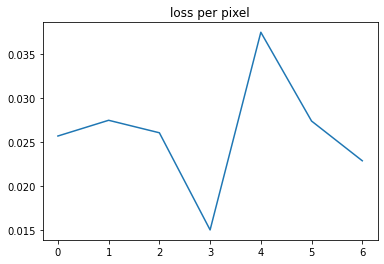

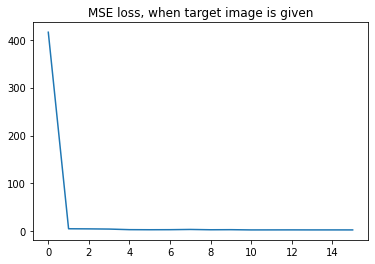

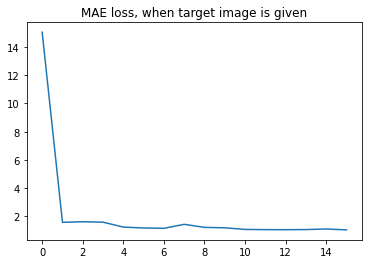

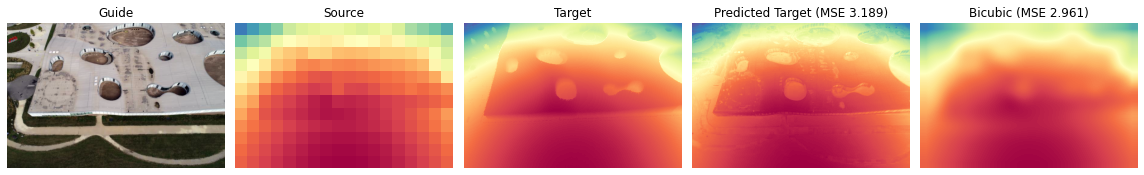

MSE: 3.189  ---  MAE: 1.039  ---  PBP: 0.300



####### image 4/10 - image idx 3 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[361.89087   34.98387   30.00618   25.458633  25.867825  21.889753
  24.230154  18.960682  17.915192  18.465446  16.098427  17.564737
  15.366121  16.430891  17.456894  14.504323]
----------MAE----------
(16,)
[14.304959   4.067492   3.904579   3.4185114  3.6608832  3.1780298
  3.3031359  2.9359636  2.8908982  2.9378686  2.6389368  2.8558717
  2.6053286  2.6793656  2.8606746  2.4936564]


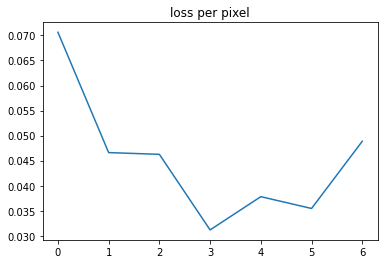

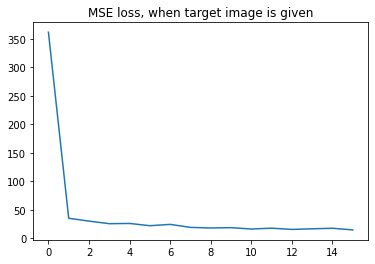

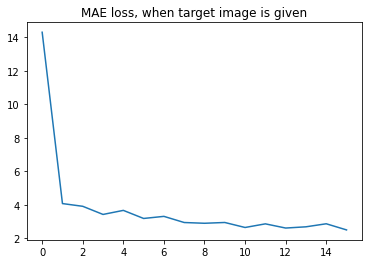

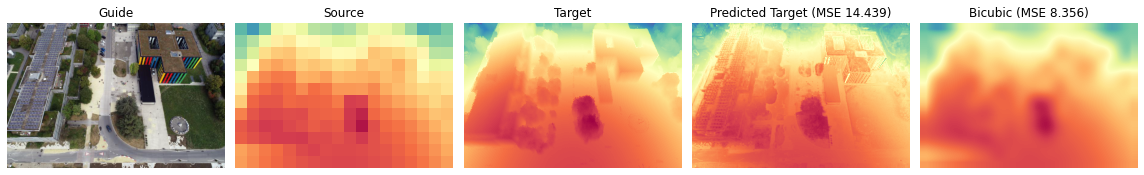

MSE: 14.439  ---  MAE: 2.510  ---  PBP: 0.616



####### image 5/10 - image idx 4 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[284.4294    37.463963  33.80383   34.711136  30.079403  28.991617
  28.45193   26.61059   24.038166  24.647928  22.733809  22.098536
  21.764416  19.877766  21.148565  22.214092]
----------MAE----------
(16,)
[12.134799   4.101404   3.8827567  3.7941382  3.482275   3.473413
  3.44353    3.2363505  3.255367   3.1856387  3.1088252  2.8873408
  2.9107466  2.8810365  2.9201157  2.9253705]


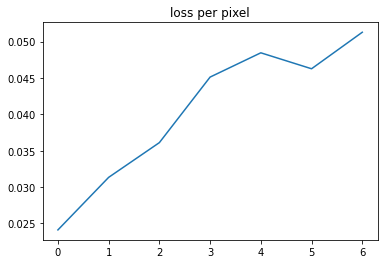

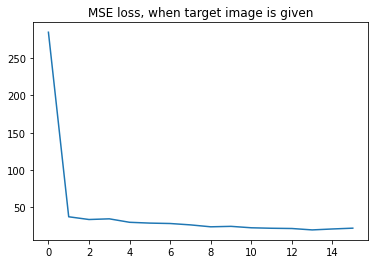

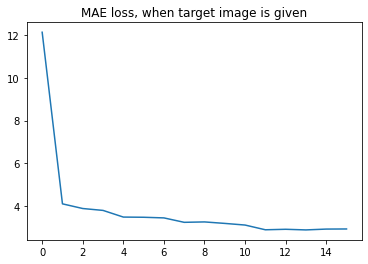

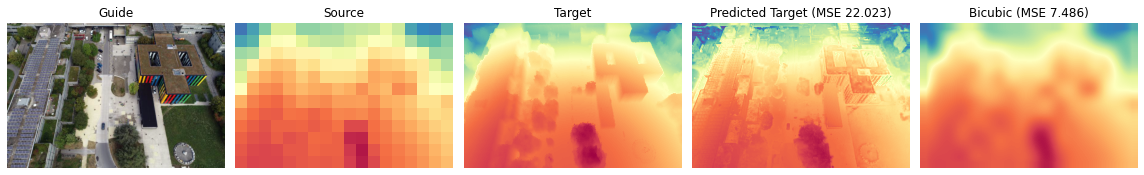

MSE: 22.023  ---  MAE: 2.987  ---  PBP: 0.665



####### image 6/10 - image idx 5 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[330.57974   30.292349  20.483059  18.604969  17.189013  15.999412
  14.476314  14.701169  14.499283  14.090798  14.198788  12.232511
  13.269314  13.269361  13.240064  12.971624]
----------MAE----------
(16,)
[13.123764   3.9409535  3.0935185  2.9451182  2.8271077  2.801544
  2.58363    2.5904684  2.6161249  2.543811   2.5919905  2.3724346
  2.4561245  2.5010962  2.5219798  2.4474103]


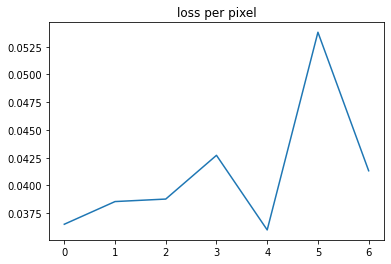

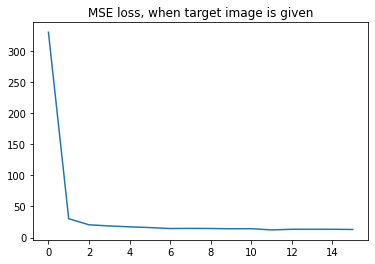

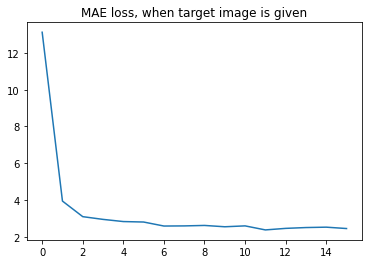

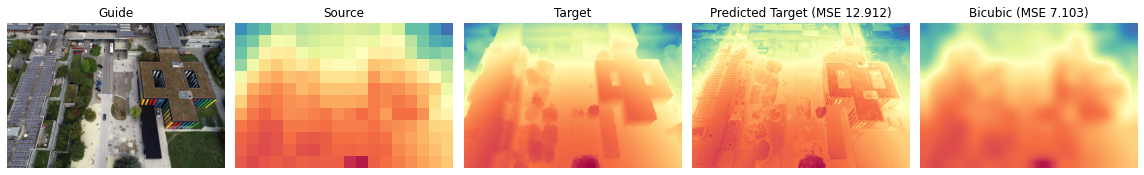

MSE: 12.912  ---  MAE: 2.464  ---  PBP: 0.652



####### image 7/10 - image idx 6 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[427.67334   43.51662   36.440174  32.096222  29.908361  28.401796
  28.761889  28.22236   26.267214  28.655594  28.292727  26.746239
  26.942709  27.379982  26.878101  28.25897 ]
----------MAE----------
(16,)
[14.844712   4.710249   4.2527866  3.9527733  3.8113477  3.7121458
  3.7407088  3.6496203  3.482696   3.7054281  3.6293254  3.5383055
  3.600798   3.60297    3.6143503  3.5883934]


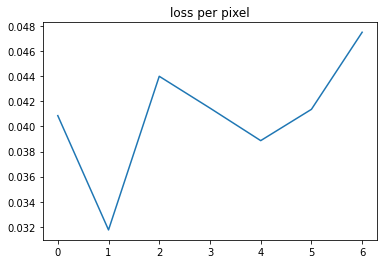

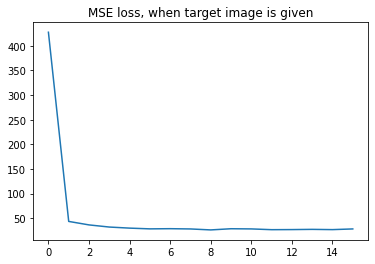

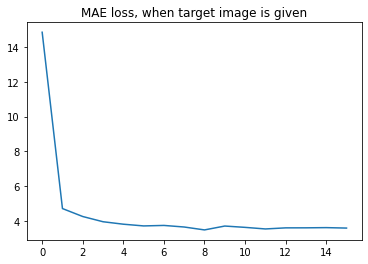

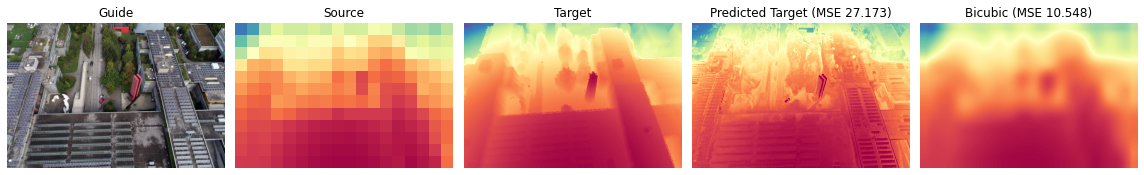

MSE: 27.173  ---  MAE: 3.492  ---  PBP: 0.710



####### image 8/10 - image idx 7 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[469.00684   43.45332   35.852047  37.490856  31.283386  31.551435
  32.467785  29.253368  28.298525  28.033464  27.271027  25.892551
  28.8726    30.26501   27.764711  27.62115 ]
----------MAE----------
(16,)
[16.323065   4.7800326  4.153132   4.3267655  3.8133578  3.8604777
  3.9202847  3.6407032  3.5498216  3.5182877  3.492288   3.3382084
  3.56449    3.612147   3.4250453  3.3679621]


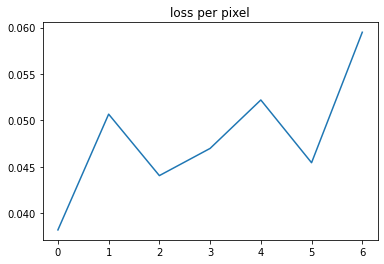

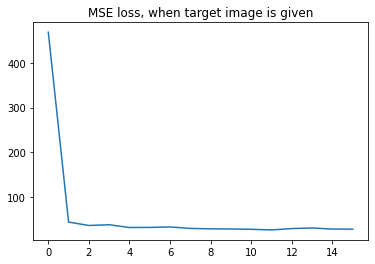

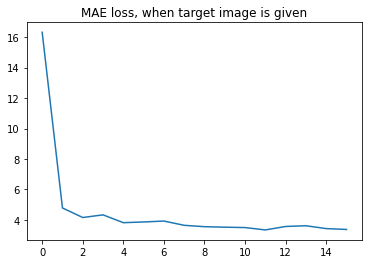

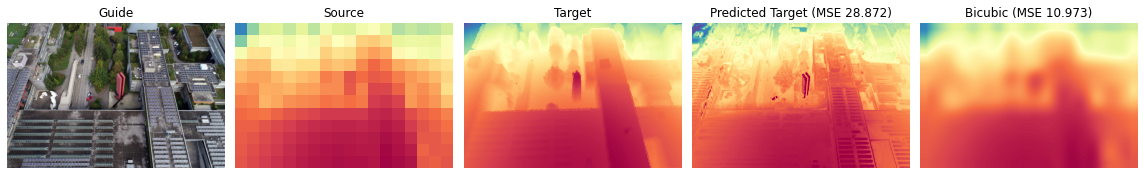

MSE: 28.872  ---  MAE: 3.472  ---  PBP: 0.685



####### image 9/10 - image idx 8 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[554.96936   40.80333   32.756584  39.06186   33.134335  30.572338
  29.26669   31.764328  29.076025  29.22414   29.706432  31.806595
  29.919647  29.717842  29.398958  29.758827]
----------MAE----------
(16,)
[17.710623   4.4799905  4.01789    4.512715   4.069961   3.9188714
  3.8026237  3.9377966  3.7522306  3.7971375  3.8066103  3.9944913
  3.8464952  3.8517842  3.804202   3.8768497]


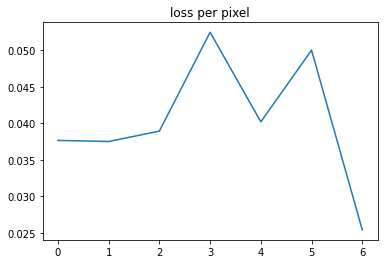

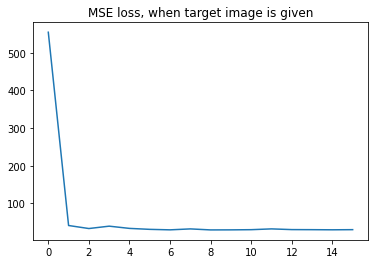

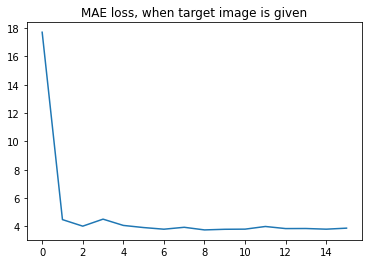

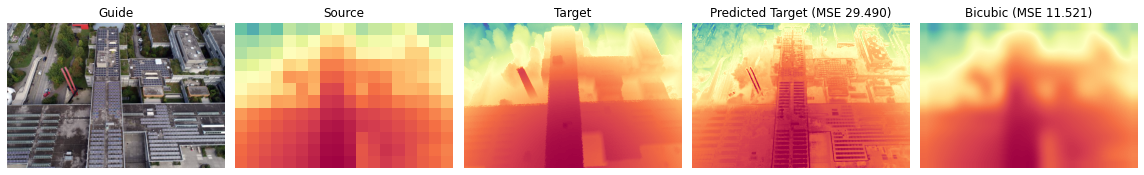

MSE: 29.490  ---  MAE: 3.849  ---  PBP: 0.772



####### image 10/10 - image idx 9 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[363.93625   41.72884   35.99755   34.503635  36.328968  31.22897
  30.354399  28.576391  26.888533  27.977297  28.053356  26.070387
  27.83592   25.019474  25.258512  25.26305 ]
----------MAE----------
(16,)
[14.711056   4.718917   4.3722587  4.28405    4.469654   4.140053
  4.048676   3.8547337  3.740267   3.7681134  3.7291305  3.5802119
  3.693282   3.4729044  3.4696958  3.4665632]


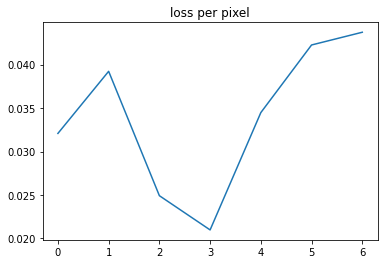

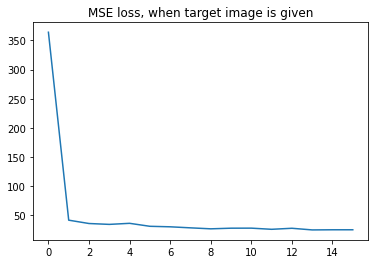

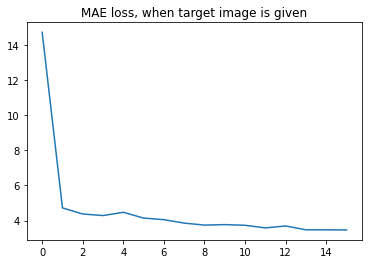

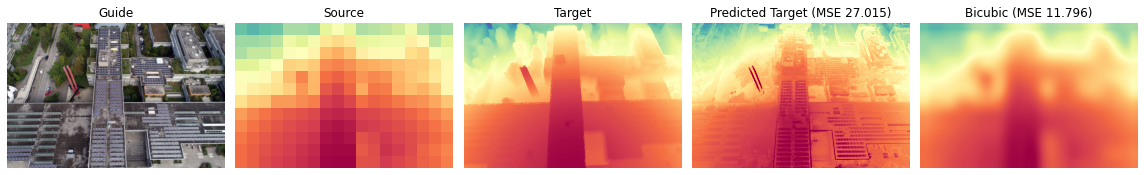

MSE: 27.015  ---  MAE: 3.596  ---  PBP: 0.756





In [15]:
####  define parameters  ########################################################
params = {'img_idxs' : [], # idx images to process, if empty then all of them
            
          'scaling': 40,
          'greyscale': False, # Turn image into grey-scale
          'channels': -1,
          
          'spatial_features_input': True,
          'weights_regularizer': [0.0001, 0.001, 0.0001], # spatial color head
          'loss': 'l1',
 
          'optim': 'adam',
          'lr': 0.001,
                  
          'batch_size': 32,
          'iteration': 1024*12*18//32,
                  
          'logstep': 64,
          
          'final_TGV' : False, # Total Generalized Variation in post-processing
          'align': False, # Move image around for evaluation in case guide image and target image are not perfectly aligned
          'delta_PBP': 1, # Delta for percentage of bad pixels 
         }

#### train and plot the results ################################################
if len(params['img_idxs'])==0:
    idxs = np.array(range(0,target_imgs.shape[0]))
else:
    idxs = params['img_idxs']

constant = 10
    
for n_image,idx in enumerate(idxs):
    
    print("####### image {}/{} - image idx {} ########".format(n_image+1,len(idxs),idx))
    
    guide_img = guide_imgs[idx]
    target_img = target_imgs[idx]
    source_img = downsample(target_img,params['scaling'])
    save_path = directory+'/saved_model_EPFL_oblique/model'+str(constant + idx)+'.pt'
    # check if the directory exist
    os.makedirs(os.path.dirname(save_path),exist_ok=True)
    
    bicubic_target_img = bicubic(source_img=source_img, scaling_factor=params['scaling'])
    
    predicted_target_img = PixTransform(guide_img=guide_img,source_img=source_img,params=params,target_img=target_img, path = save_path)
    


    if params['final_TGV'] :
        print("applying TGV...")
        predicted_target_img = tvgen(predicted_target_img,[0.1, 0.1],[1, 2],[1, 1])
        
    if params['align'] :
        print("aligning...")
        target_img,predicted_target_img = align_images(target_img,predicted_target_img)

    f, ax = plot_result(guide_img,source_img,predicted_target_img,bicubic_target_img,target_img)
    plt.show()
    
    if target_img is not None:
        # compute metrics and plot results
        MSE = np.mean((predicted_target_img - target_img) ** 2)
        MAE = np.mean(np.abs(predicted_target_img - target_img))
        PBP = np.mean(np.abs(predicted_target_img - target_img) > params["delta_PBP"])

        print("MSE: {:.3f}  ---  MAE: {:.3f}  ---  PBP: {:.3f}".format(MSE,MAE,PBP))
        print("\n\n")
 



### Change upsampling to 90， here first try crop the image to 450x720

In [16]:
torch.cuda.empty_cache()

In [17]:
## crop images
new_guide_imgs = guide_imgs[:,:,:450,:]
new_target_imgs = target_imgs[:,:450,:]
print(new_guide_imgs.shape)
print(new_target_imgs.shape)

(10, 3, 450, 720)
(10, 450, 720)


####### image 1/10 - image idx 0 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[499.17487   23.28383   13.69254   11.449823  18.534828  11.876078
  13.439562  13.324494  12.937275  11.665031  11.008132  12.317343
  10.48499   12.589599  11.195364  11.264533]
----------MAE----------
(16,)
[17.717781   3.1951375  2.6831274  2.2480004  2.8485873  2.22439
  2.379464   2.3981173  2.3631508  2.1782866  2.169383   2.3466957
  2.1026702  2.2327602  2.1092975  2.2614386]


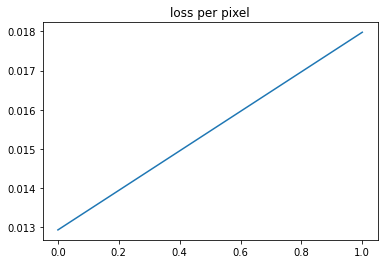

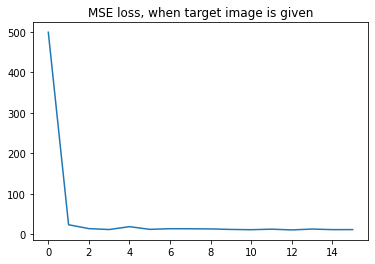

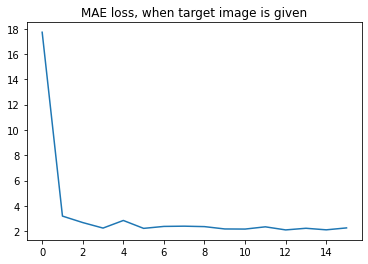

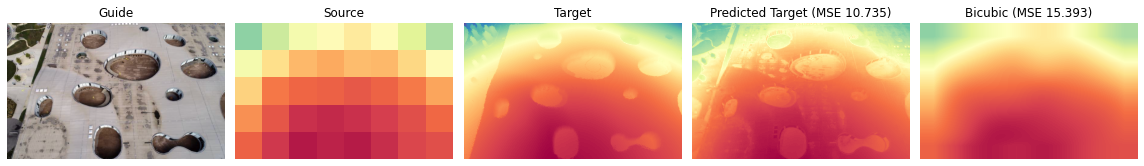

MSE: 10.735  ---  MAE: 2.062  ---  PBP: 0.532



####### image 2/10 - image idx 1 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[490.20395   55.010162  52.112137  47.66654   36.970024  32.196323
  36.231773  41.563816  39.205944  44.507534  36.44873   38.977325
  37.280205  39.216526  35.287113  34.152027]
----------MAE----------
(16,)
[15.959737   5.248871   4.875986   4.652508   3.9482923  3.5126848
  3.8234353  4.303315   4.31221    3.8828874  3.7122092  3.7767587
  3.6700842  3.6849391  3.6633303  3.4347308]


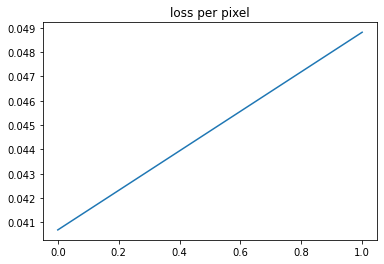

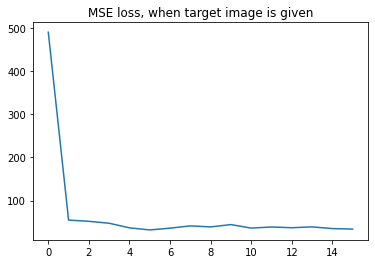

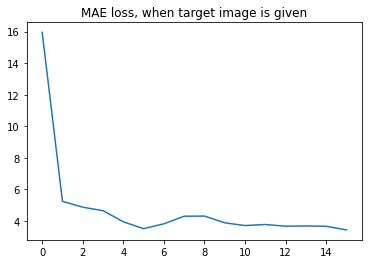

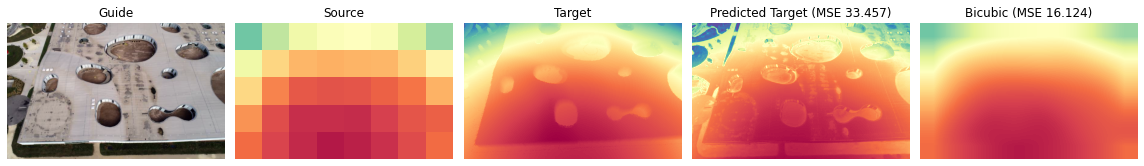

MSE: 33.457  ---  MAE: 3.440  ---  PBP: 0.700



####### image 3/10 - image idx 2 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[437.03503   46.896736  35.327206  28.538776  28.483004  23.24657
  23.718307  22.793268  23.415806  23.998232  22.192474  21.547785
  20.918598  19.117765  21.449127  20.26682 ]
----------MAE----------
(16,)
[15.458527   5.0508537  4.30025    3.6902351  3.799818   3.3036945
  3.1946015  3.2059357  3.334663   3.2727292  3.141541   3.1620045
  3.0963368  2.9194155  3.1148899  3.0039284]


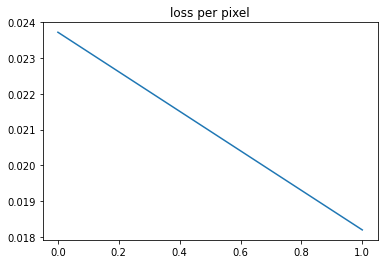

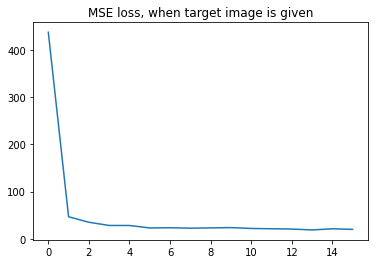

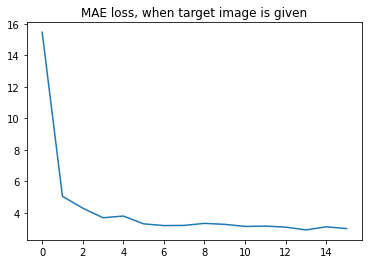

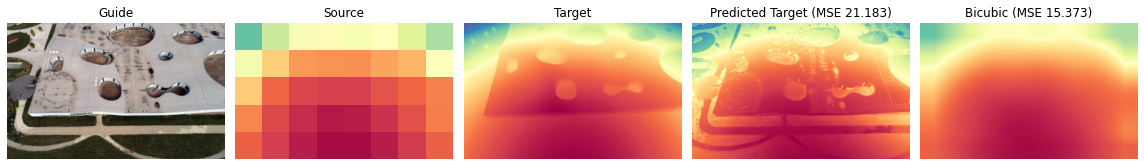

MSE: 21.183  ---  MAE: 3.093  ---  PBP: 0.715



####### image 4/10 - image idx 3 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[388.0202    68.8898    53.70147   53.942978  55.24659   63.89486
  58.516804  55.092464  56.08612   59.38579   57.71162   56.293884
  57.103348  56.619965  56.950817  57.390705]
----------MAE----------
(16,)
[15.504802   5.7267704  5.10315    5.1658497  5.1744747  5.6462207
  5.314531   5.2177434  5.2366986  5.4308467  5.316638   5.274804
  5.2934     5.2475038  5.2739406  5.3012238]


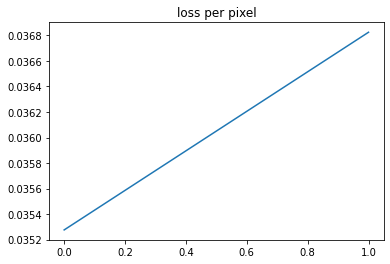

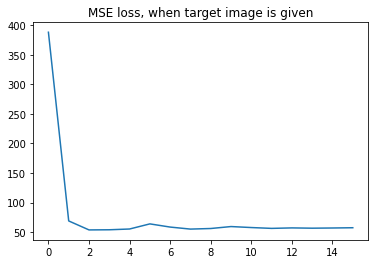

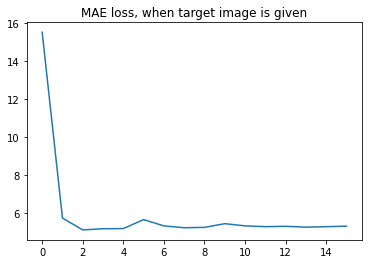

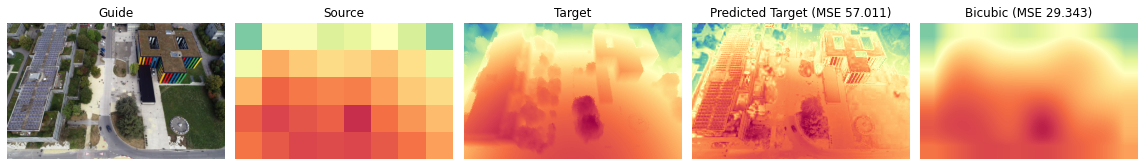

MSE: 57.011  ---  MAE: 5.271  ---  PBP: 0.815



####### image 5/10 - image idx 4 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[393.44342   59.1161    54.984447  64.86226   66.176285  69.56351
  66.395584  63.88742   67.27467   68.061806  66.89283   64.46123
  62.56108   65.75881   64.2185    66.73131 ]
----------MAE----------
(16,)
[15.783871   5.4433856  5.322626   5.7074337  5.839084   5.8771944
  5.6657004  5.8250027  5.717923   5.743102   5.6628685  5.616528
  5.5233645  5.615617   5.540156   5.7352014]


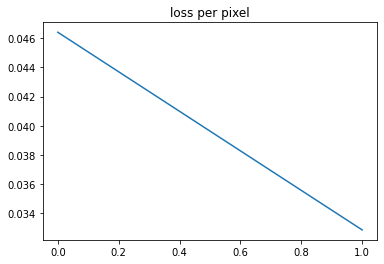

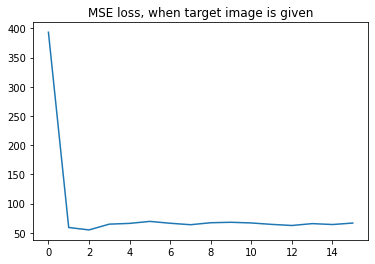

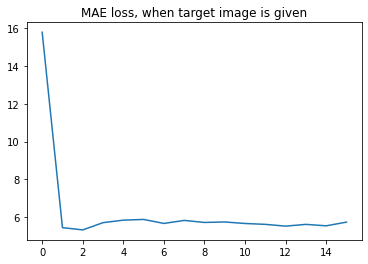

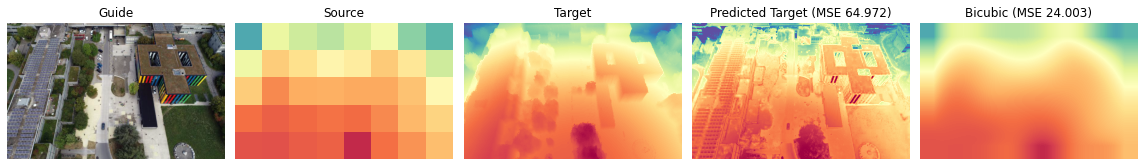

MSE: 64.972  ---  MAE: 5.627  ---  PBP: 0.819



####### image 6/10 - image idx 5 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[404.18265   73.36669   73.223816  78.365814  85.32268   82.66186
  87.598236  84.00225   80.9552    79.52026   82.299065  78.933395
  80.7341    75.33911   77.09334   75.2982  ]
----------MAE----------
(16,)
[14.713464   6.2586083  5.912717   6.1615486  6.384512   6.2900586
  6.526923   6.313614   6.27394    6.1113906  6.3019857  6.1893926
  6.265535   5.981817   6.120321   6.04272  ]


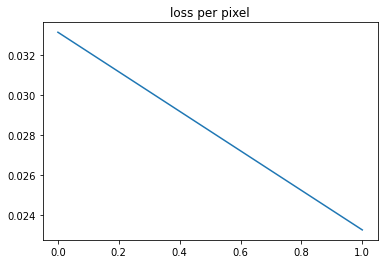

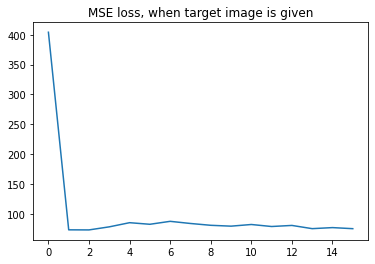

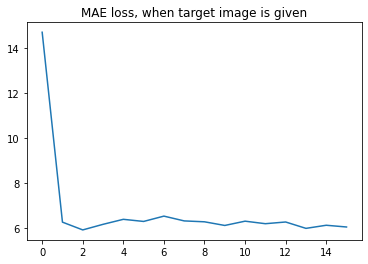

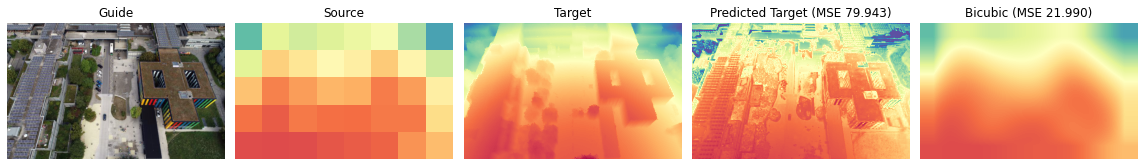

MSE: 79.943  ---  MAE: 6.231  ---  PBP: 0.828



####### image 7/10 - image idx 6 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[611.65295  100.53225   81.933655  91.22245   75.50066   86.20198
  70.15403   69.7067    75.7854    69.67113   70.94024   67.602455
  70.035164  72.261765  62.083385  69.48842 ]
----------MAE----------
(16,)
[18.51244    7.790006   6.7749863  7.197038   6.3734136  6.8945665
  6.1303062  6.0804267  6.478832   5.9994383  6.286673   5.952035
  6.094673   6.185983   5.7237124  5.9951777]


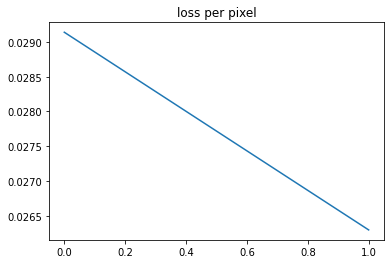

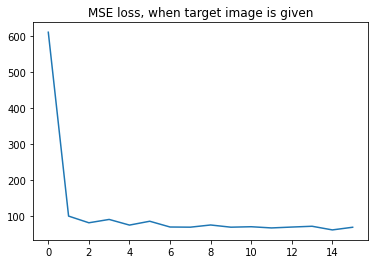

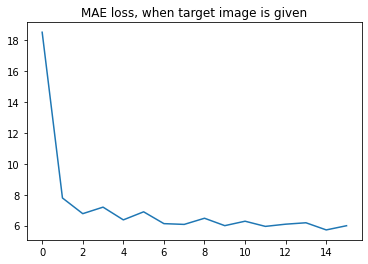

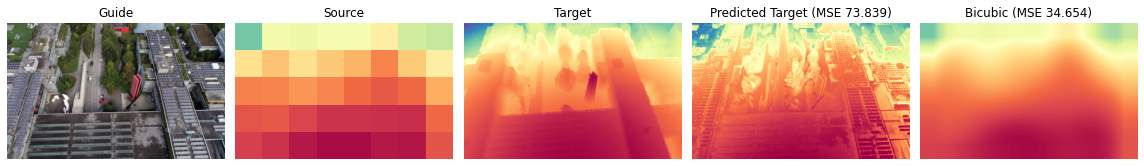

MSE: 73.839  ---  MAE: 6.208  ---  PBP: 0.858



####### image 8/10 - image idx 7 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[598.8352   118.40651  104.781494 107.75773  107.88761  112.99541
 107.77162  113.61183  100.90973  109.122345 104.29463   96.25106
 105.98891  105.22791   97.32536  103.21665 ]
----------MAE----------
(16,)
[18.244287   7.505386   7.279998   7.479079   7.395304   7.5227995
  7.2666855  7.5509915  7.024406   7.2795944  7.0794787  6.761969
  7.1882534  7.098267   6.7547994  7.0482254]


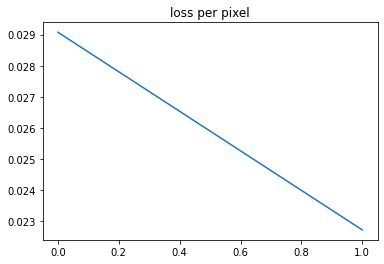

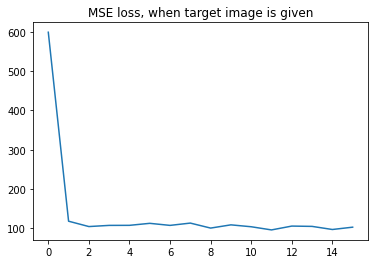

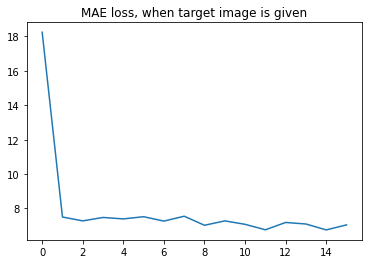

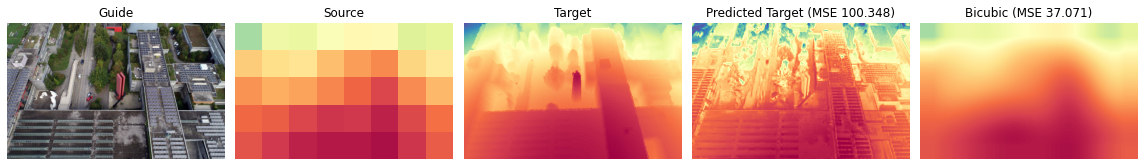

MSE: 100.348  ---  MAE: 6.889  ---  PBP: 0.872



####### image 9/10 - image idx 8 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[496.28412   87.34325   58.476593  57.543583  62.50968   60.332706
  56.746563  59.899643  65.79404   69.782715  65.73172   72.434265
  71.69482   79.98147   76.92167   76.44248 ]
----------MAE----------
(16,)
[17.991503   6.9822044  5.697399   5.4710517  5.729562   5.492876
  5.386192   5.4215817  5.7214622  5.9455366  5.7537103  6.1257596
  5.984256   6.3792696  6.3326735  6.286585 ]


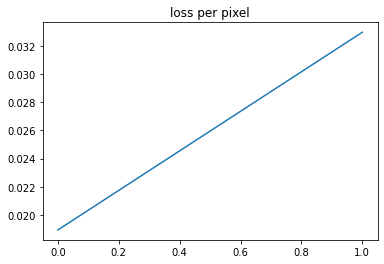

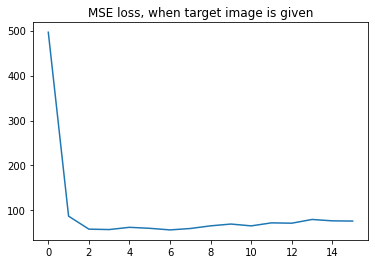

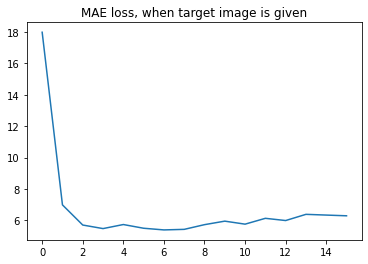

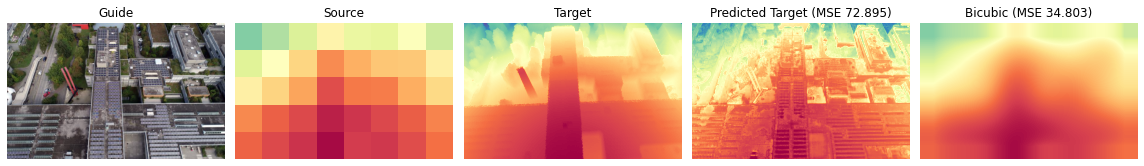

MSE: 72.895  ---  MAE: 6.090  ---  PBP: 0.866



####### image 10/10 - image idx 9 ########


  0%|          | 0/1024 [00:00<?, ?it/s]

----------MSE----------
(16,)
[469.525     71.66741   69.39279   50.434807  58.85468   57.121323
  62.675793  64.80248   65.204765  64.40321   70.47801   71.390755
  71.0148    67.56843   71.35189   68.41818 ]
----------MAE----------
(16,)
[17.519087   6.2033496  6.086119   5.140691   5.6615896  5.3909974
  5.658841   5.7969475  5.766126   5.7801223  5.955489   6.0536942
  5.986163   5.7409387  5.9229593  5.8440275]


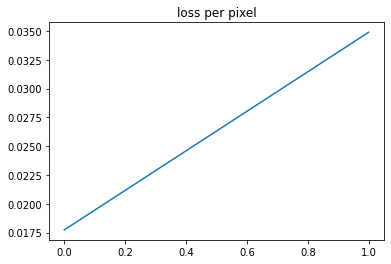

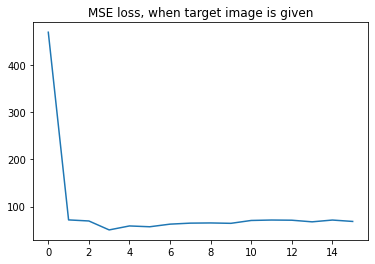

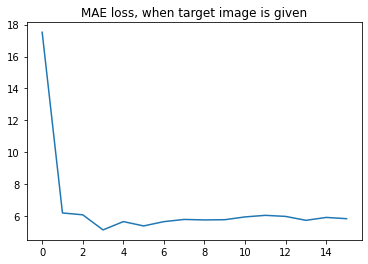

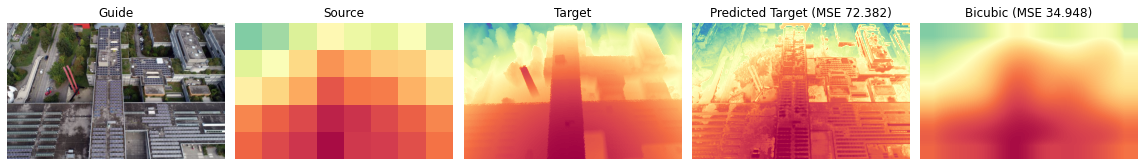

MSE: 72.382  ---  MAE: 5.998  ---  PBP: 0.877





In [18]:
####  define parameters  ########################################################
params = {'img_idxs' : [], # idx images to process, if empty then all of them
            
          'scaling': 90,
          'greyscale': False, # Turn image into grey-scale
          'channels': -1,
          
          'spatial_features_input': True,
          'weights_regularizer': [0.0001, 0.001, 0.0001], # spatial color head
          'loss': 'l1',
 
          'optim': 'adam',
          'lr': 0.001,
                  
          'batch_size': 32,
          'iteration': 1024*5*8//32,
                  
          'logstep': 64,
          
          'final_TGV' : False, # Total Generalized Variation in post-processing
          'align': False, # Move image around for evaluation in case guide image and target image are not perfectly aligned
          'delta_PBP': 1, # Delta for percentage of bad pixels 
         }

if len(params['img_idxs'])==0:
    idxs = np.array(range(0,new_target_imgs.shape[0]))
else:
    idxs = params['img_idxs']

constant = 20
    
for n_image,idx in enumerate(idxs):
    
    print("####### image {}/{} - image idx {} ########".format(n_image+1,len(idxs),idx))
    
    guide_img = new_guide_imgs[idx]
    target_img = new_target_imgs[idx]
    source_img = downsample(target_img,params['scaling'])
    save_path = directory+'/saved_model_EPFL_oblique/model'+str(constant + idx)+'.pt'
    # check if the directory exist
    os.makedirs(os.path.dirname(save_path),exist_ok=True)
    
    bicubic_target_img = bicubic(source_img=source_img, scaling_factor=params['scaling'])
    
    predicted_target_img = PixTransform(guide_img=guide_img,source_img=source_img,params=params,target_img=target_img, path = save_path)
    


    if params['final_TGV'] :
        print("applying TGV...")
        predicted_target_img = tvgen(predicted_target_img,[0.1, 0.1],[1, 2],[1, 1])
        
    if params['align'] :
        print("aligning...")
        target_img,predicted_target_img = align_images(target_img,predicted_target_img)

    f, ax = plot_result(guide_img,source_img,predicted_target_img,bicubic_target_img,target_img)
    plt.show()
    
    if target_img is not None:
        # compute metrics and plot results
        MSE = np.mean((predicted_target_img - target_img) ** 2)
        MAE = np.mean(np.abs(predicted_target_img - target_img))
        PBP = np.mean(np.abs(predicted_target_img - target_img) > params["delta_PBP"])

        print("MSE: {:.3f}  ---  MAE: {:.3f}  ---  PBP: {:.3f}".format(MSE,MAE,PBP))
        print("\n\n")
 

In [19]:
import torch
torch.cuda.empty_cache()